# Описание задания

**Цель лабораторной работы:** изучение ансамблей моделей машинного обучения.


# Задание

1.	Выберите набор данных (датасет) для решения задачи классификации или регресии.
2.	В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
3.	С использованием метода train_test_split разделите выборку на обучающую и тестовую.
4.	Обучите две ансамблевые модели. Оцените качество моделей с помощью одной из подходящих для задачи метрик. Сравните качество полученных моделей.
5.	Произведите для каждой модели подбор значений одного гиперпараметра. В зависимости от используемой библиотеки можно применять функцию GridSearchCV, использовать перебор параметров в цикле, или использовать другие методы.
6.	Повторите пункт 4 для найденных оптимальных значений гиперпараметров. Сравните качество полученных моделей с качеством моделей, полученных в пункте 4.








# Ход выполнения лабораторной работы

## Выбор датасета

В качестве исходных данных выбираем датасет о террористических атаках. Он содержит около 180 тысячи записей, а также имеет разные столбцы с категориальными данными. Такой датасет может подходить для обучения методом ближайших соседей.

В качестве задачи поставим определение вида атаки по остальным колонкам.

## Проверка и удаление пропусков

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
!pip install git+git://github.com/kvoyager/GmdhPy.git

  Cloning git://github.com/kvoyager/GmdhPy.git to /tmp/pip-req-build-h3m6u23s
  Stored in directory: /tmp/pip-ephem-wheel-cache-hp547vc8/wheels/69/6c/43/d6d9c8729bf1a2dce40efe68fa2919dad6f2d69fbc9e58353b
Successfully built GmdhPy


In [5]:
from google.colab import drive, files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from google.colab import files
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
os.listdir()
data = pd.read_csv('drive/My Drive/Files/globalterrorismdb_0718dist.csv',
                   sep=",", encoding="iso-8859-1")

Количество пустых колонок огромно, поэтому сначала удалим все столбцы, у которых количество заполненных значений менее 150000 (примерно 5/6 от всего датасета), а затем удалим строки с пустым значением.

In [7]:
# Удаление колонок, содержащих пустые значения
data_temp_1 = data.dropna(axis=1, how='any', thresh=150000)
(data.shape, data_temp_1.shape)

((181691, 135), (181691, 47))

In [8]:
data_new_1 = data_temp_1.dropna(axis=0, how='any')
(data_temp_1.shape, data_new_1.shape)

((181691, 47), (134042, 47))

In [9]:
data_new_1.head()

,eventid,iyear,imonth,iday,extended,country,country_txt,region,region_txt,provstate,...,weapsubtype1_txt,nkill,nwound,property,ishostkid,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY
5,197001010002,1970,1,1,0,217,United States,1,North America,Illinois,...,Unknown Gun Type,0.0,0.0,1,0.0,Hewitt Project,-9,-9,0,-9
6,197001020001,1970,1,2,0,218,Uruguay,3,South America,Montevideo,...,Automatic or Semi-Automatic Rifle,0.0,0.0,0,0.0,PGIS,0,0,0,0
7,197001020002,1970,1,2,0,217,United States,1,North America,California,...,Unknown Explosive Type,0.0,0.0,1,0.0,Hewitt Project,-9,-9,0,-9
8,197001020003,1970,1,2,0,217,United States,1,North America,Wisconsin,...,Molotov Cocktail/Petrol Bomb,0.0,0.0,1,0.0,Hewitt Project,0,0,0,0
9,197001030001,1970,1,3,0,217,United States,1,North America,Wisconsin,...,Gasoline or Alcohol,0.0,0.0,1,0.0,Hewitt Project,0,0,0,0


In [10]:
data2 = data_new_1.drop(["provstate", "eventid",
                 "dbsource", "INT_LOG", "INT_IDEO", "INT_MISC",
                 "INT_ANY", "individual", "weapsubtype1",
                 "weapsubtype1_txt", "property", "vicinity", "crit2",
                 "crit3", "natlty1", "iday", "imonth", "iyear",
                 "extended"], axis=1)
data2.shape

(134042, 28)

## train_test_split



In [0]:
from sklearn.model_selection import train_test_split
attacktype = data2["attacktype1"]
data3 = data2.drop(["attacktype1"], axis=1)
for col in data3.columns:
  dt = str(data[col].dtype)
  if not (dt=='float64' or dt=='int64'):
    data3 = data3.drop([col], axis=1)
data_X_train, data_X_test, data_y_train, data_y_test = train_test_split(
    data3, attacktype, test_size=0.2, random_state=1)

## Обучение 

In [0]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import mean_squared_error

In [0]:
template = "Отклонение на тренируемой выборке: {:.3f} \
отклонение на тестовой выборке: {:.3f}"

In [0]:
class Classifier():
  def __init__(self, method, x_train, y_train, x_test, y_test):
    self._method = method
    self.x_train = x_train
    self.y_train = y_train
    self.x_test = x_test
    self.y_test = y_test
    self.target_1 = []
    self.target_2 = []
   
  def training(self):
    self._method.fit(self.x_train, self.y_train)
    self.target_1 = self._method.predict(self.x_train)
    self.target_2 = self._method.predict(self.x_test)
    
  def result(self, metric):
    print(template.format(metric(self.y_train, self.target_1), 
                      metric(self.y_test, self.target_2)))
    

### RandomForestClassifier

In [57]:
rfr = Classifier(RandomForestClassifier(max_features=1), data_X_train, 
                    data_y_train, data_X_test, data_y_test)
rfr.training()
rfr.result(mean_squared_error)

Отклонение на тренируемой выборке: 0.062 отклонение на тестовой выборке: 0.635


### GradientBoostingClassifier


In [58]:
gbc = Classifier(GradientBoostingClassifier(max_features=1), data_X_train, 
                    data_y_train, data_X_test, data_y_test)
gbc.training()
gbc.result(mean_squared_error)

Отклонение на тренируемой выборке: 0.689 отклонение на тестовой выборке: 0.701


Видно, что на тестовой выборке обе ансамблевые модели ведут себя почти одинаково.


## Подбор гиперпараметра K с использованием GridSearchCV и кросс-валидации

### RandomForestClassifier

In [35]:
n_range = np.array(range(3,10,1))
tuned_parameters = [{'max_features': n_range}]
tuned_parameters

[{'max_features': array([3, 4, 5, 6, 7, 8, 9])}]

In [37]:
from sklearn.model_selection import GridSearchCV

cl_rfc_gs = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=5,
                      scoring='accuracy')
cl_rfc_gs.fit(data_X_train, data_y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'max_features': array([3, 4, 5, 6, 7, 8, 9])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [38]:
cl_rfc_gs.best_params_

{'max_features': 6}

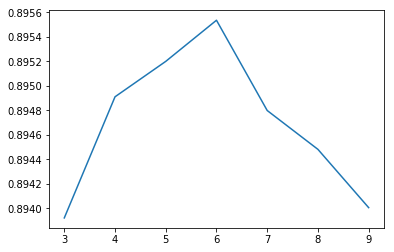

In [39]:
plt.plot(n_range, cl_rfc_gs.cv_results_['mean_test_score'])

Как и говорит теория, $dl$ примерно равно $\sqrt{D}$

### GradientBoostingClassifier

In [43]:
n_range = np.array(range(4,9,1))
tuned_parameters = [{'max_features': n_range}]
tuned_parameters

[{'max_features': array([4, 5, 6, 7, 8])}]

In [44]:
cl_gbc_gs = GridSearchCV(GradientBoostingClassifier(), tuned_parameters, cv=3,
                      scoring='accuracy')
cl_gbc_gs.fit(data_X_train, data_y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'max_features': array([4, 5, 6, 7, 8])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [45]:
cl_gbc_gs.best_params_

{'max_features': 8}

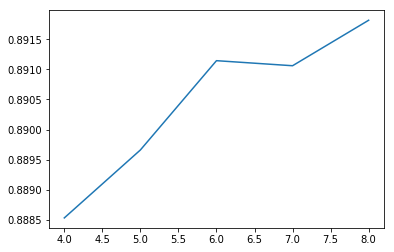

In [46]:
plt.plot(n_range, cl_gbc_gs.cv_results_['mean_test_score'])

## Сравнение модели с произвольным и лучшим параметром K

In [56]:
rfr2 = Classifier(RandomForestClassifier(max_features=6), data_X_train, 
                    data_y_train, data_X_test, data_y_test)
rfr2.training()
rfr2.result(mean_squared_error)

Отклонение на тренируемой выборке: 0.071 отклонение на тестовой выборке: 0.622


In [59]:
rfr.result(mean_squared_error)

Отклонение на тренируемой выборке: 0.062 отклонение на тестовой выборке: 0.635


In [50]:
gbc2 = Classifier(GradientBoostingClassifier(max_features=8), data_X_train, 
                    data_y_train, data_X_test, data_y_test)
gbc2.training()
gbc2.result(mean_squared_error)

Отклонение на тренируемой выборке: 0.607 отклонение на тестовой выборке: 0.650


In [60]:
gbc.result(mean_squared_error)

Отклонение на тренируемой выборке: 0.689 отклонение на тестовой выборке: 0.701


Как можно заметить, для классификатора градиентного спуска правильный подбор гиперпараметра существеннее исправил ошибку. Однако по итогу отклонение на тестовой выборке несущественно отличается.

